In [2]:
from CNN_Openface import CNN_Openface
from CNN_dataset_Openface import WindowedUBFCPhysDataset
from GradCAM import GradCAM

import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import tensorflow
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

2025-01-07 15:56:28.988166: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 15:56:29.002626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736261789.015945  123798 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736261789.020008  123798 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 15:56:29.035849: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

/work/AML_Project/5_Models/dataset_Openface_copy.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(fpath)  # {'tensor':..., 'eda':..., 'landmarks':...}

Scaled Landmarks: tensor([ 57.9484,  77.4454,  58.6819,  86.9468,  60.3324,  96.2689,  62.5330,
        105.2325,  66.3840, 113.2997,  72.0688, 120.1120,  80.5043, 124.7731,
         89.6734, 127.6415,  99.2092, 128.0000, 107.8281, 125.8487, 114.7966,
        121.5462, 120.6648, 115.8095, 123.9656, 108.1008, 125.7994,  99.6751,
        126.7163,  91.0700, 128.0000,  82.4650, 128.0000,  73.8599,  66.9341,
         70.4538,  72.4355,  66.1513,  79.4040,  64.8964,  86.5559,  66.1513,
         92.9742,  68.1233, 101.7765,  66.6891, 107.6447,  64.0000, 113.5129,
         62.2073, 119.5645,  62.9244, 123.4155,  67.2269,  97.9255,  73.6807,
         98.2923,  78.8796,  98.4756,  83.7199,  98.8424,  89.0980,  91.8739,
         95.3726,  95.5415,  96.0896,  99.0258,  96.6275, 102.1433,  96.0896,
        105.0774,  95.0140,  75.7364,  75.8319,  79.7708,  74.2185,  84.1719,
         74.0392,  88.3897,  76.1905,  84.1719,  77.0868,  79.7708,  77.4454,
        105.4441,  75.1148, 109.1118,  72.2465

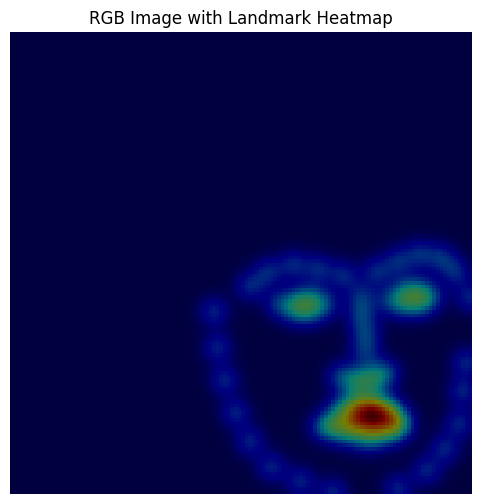

Scaled Landmarks: tensor([ 57.4619,  77.6951,  58.3827,  87.1832,  60.0403,  96.4923,  62.4345,
        105.4434,  66.3022, 113.4993,  72.1957, 120.1231,  80.4835, 124.7776,
         89.8763, 127.4629,  99.4532, 128.0000, 107.9252, 125.8518, 115.1079,
        121.5553, 120.8173, 115.6476, 124.1324, 107.9497, 125.9741,  99.5357,
        126.8950,  90.9427, 128.0000,  82.1706, 127.8158,  73.5776,  66.6705,
         70.3552,  72.0115,  65.8797,  79.0101,  64.4476,  86.3770,  65.7007,
         93.0072,  67.6699, 101.6633,  66.2378, 107.3727,  63.3734, 113.2662,
         61.4042, 119.5281,  62.1203, 123.5799,  66.2378,  97.7957,  73.2196,
         97.9799,  78.2322,  98.3482,  83.2448,  98.9007,  88.6154,  91.9022,
         95.0601,  95.4014,  95.7762,  98.9007,  96.3133, 102.2158,  95.5972,
        105.1626,  94.5231,  75.5108,  75.5469,  79.5626,  73.7566,  83.9827,
         73.5776,  88.0345,  75.5469,  83.9827,  76.8000,  79.5626,  76.9790,
        105.5309,  74.4727, 109.3986,  71.6084

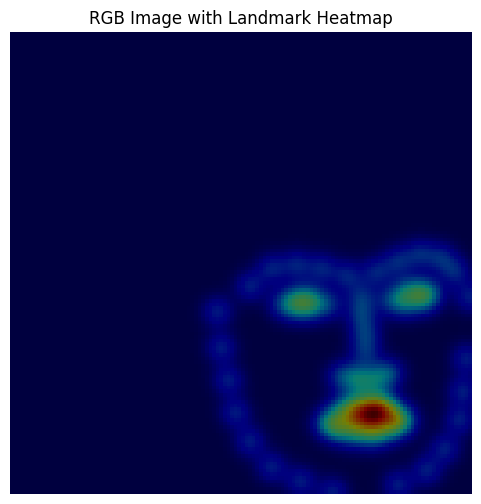

Scaled Landmarks: tensor([ 57.6824,  77.5161,  58.7811,  86.8252,  60.4292,  96.3133,  62.6266,
        105.2643,  66.4721, 113.4993,  72.5150, 120.3021,  80.9385, 124.7776,
         90.2775, 127.6420,  99.6166, 128.0000, 108.2232, 125.8518, 115.1817,
        121.3762, 120.8584, 115.4685, 124.1545, 107.7706, 125.8026,  99.3566,
        126.7182,  90.9427, 127.8169,  82.3497, 128.0000,  73.7566,  67.0215,
         70.3552,  72.5150,  66.0587,  79.6567,  64.6266,  86.7983,  65.8797,
         93.3906,  68.0280, 102.1803,  66.5958, 108.0401,  63.7315, 113.8999,
         61.7622, 120.1259,  62.6573, 123.9714,  66.9538,  98.3348,  73.3986,
         98.5179,  78.5902,  98.8841,  83.6028,  99.2504,  89.1525,  92.2918,
         95.4182,  95.9542,  96.1343,  99.4335,  96.4923, 102.5465,  95.7762,
        105.4764,  94.7021,  76.1774,  75.5469,  80.3891,  73.9357,  84.7840,
         73.7566,  88.6295,  75.7259,  84.6009,  76.8000,  80.2060,  76.9790,
        106.0258,  74.8308, 109.8712,  72.1455

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].


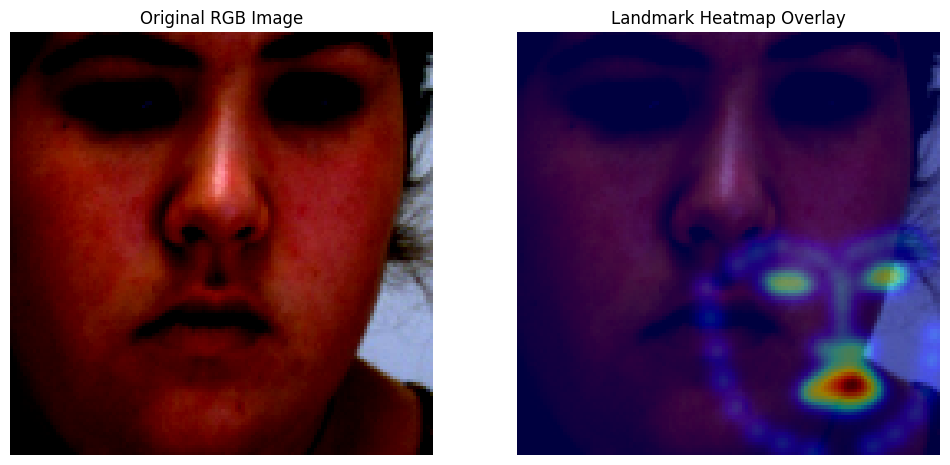

/work/AML_Project/5_Models/dataset_Openface_copy.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(fpath)  # {'tensor':..., 'eda':..., 'landmarks':...}

Scaled Landmarks: tensor([ 57.4619,  77.6951,  58.3827,  87.1832,  60.0403,  96.4923,  62.4345,
        105.4434,  66.3022, 113.4993,  72.1957, 120.1231,  80.4835, 124.7776,
         89.8763, 127.4629,  99.4532, 128.0000, 107.9252, 125.8518, 115.1079,
        121.5553, 120.8173, 115.6476, 124.1324, 107.9497, 125.9741,  99.5357,
        126.8950,  90.9427, 128.0000,  82.1706, 127.8158,  73.5776,  66.6705,
         70.3552,  72.0115,  65.8797,  79.0101,  64.4476,  86.3770,  65.7007,
         93.0072,  67.6699, 101.6633,  66.2378, 107.3727,  63.3734, 113.2662,
         61.4042, 119.5281,  62.1203, 123.5799,  66.2378,  97.7957,  73.2196,
         97.9799,  78.2322,  98.3482,  83.2448,  98.9007,  88.6154,  91.9022,
         95.0601,  95.4014,  95.7762,  98.9007,  96.3133, 102.2158,  95.5972,
        105.1626,  94.5231,  75.5108,  75.5469,  79.5626,  73.7566,  83.9827,
         73.5776,  88.0345,  75.5469,  83.9827,  76.8000,  79.5626,  76.9790,
        105.5309,  74.4727, 109.3986,  71.6084

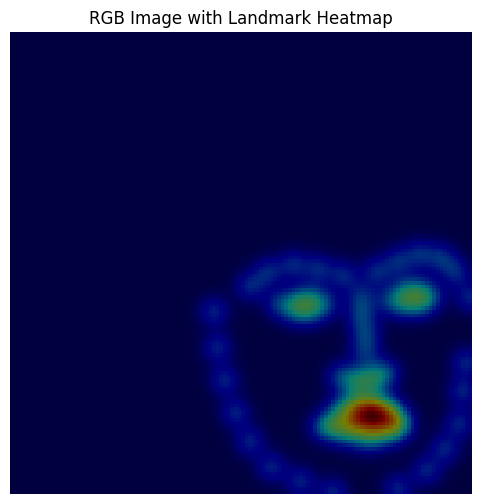

Scaled Landmarks: tensor([ 57.4619,  77.6951,  58.3827,  87.1832,  60.0403,  96.4923,  62.4345,
        105.4434,  66.3022, 113.4993,  72.1957, 120.1231,  80.4835, 124.7776,
         89.8763, 127.4629,  99.4532, 128.0000, 107.9252, 125.8518, 115.1079,
        121.5553, 120.8173, 115.6476, 124.1324, 107.9497, 125.9741,  99.5357,
        126.8950,  90.9427, 128.0000,  82.1706, 127.8158,  73.5776,  66.6705,
         70.3552,  72.0115,  65.8797,  79.0101,  64.4476,  86.3770,  65.7007,
         93.0072,  67.6699, 101.6633,  66.2378, 107.3727,  63.3734, 113.2662,
         61.4042, 119.5281,  62.1203, 123.5799,  66.2378,  97.7957,  73.2196,
         97.9799,  78.2322,  98.3482,  83.2448,  98.9007,  88.6154,  91.9022,
         95.0601,  95.4014,  95.7762,  98.9007,  96.3133, 102.2158,  95.5972,
        105.1626,  94.5231,  75.5108,  75.5469,  79.5626,  73.7566,  83.9827,
         73.5776,  88.0345,  75.5469,  83.9827,  76.8000,  79.5626,  76.9790,
        105.5309,  74.4727, 109.3986,  71.6084

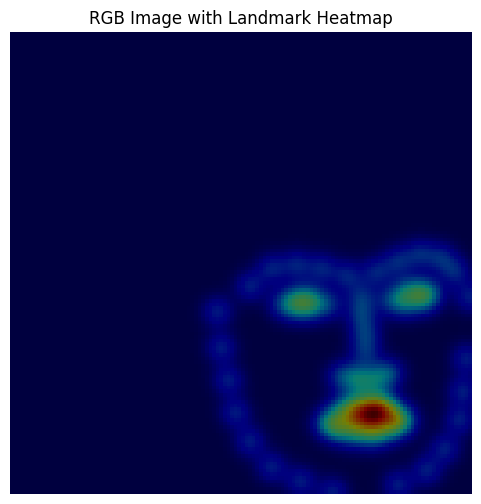

Scaled Landmarks: tensor([ 57.7471,  77.8039,  58.6667,  87.3053,  60.3218,  96.6275,  62.3448,
        105.4118,  66.2069, 113.4790,  72.0920, 120.2913,  80.3678, 124.9524,
         89.9310, 127.6415,  99.4943, 128.0000, 108.1379, 125.8487, 115.1264,
        121.7255, 120.8276, 115.9888, 123.9540, 108.2801, 125.7931,  99.8543,
        126.8966,  91.4286, 128.0000,  82.6443, 128.0000,  73.8599,  66.7586,
         70.0952,  72.0920,  65.6134,  79.2644,  64.3585,  86.4368,  65.6134,
         93.0575,  67.7647, 101.7011,  66.5098, 107.4023,  63.8207, 113.4713,
         62.0280, 119.7241,  62.7451, 123.7701,  66.8683,  98.0230,  73.1429,
         98.3908,  78.5210,  98.7586,  83.5406,  99.1264,  88.9188,  91.9540,
         95.1933,  95.6322,  96.0896,  99.1264,  96.4482, 102.2529,  95.9104,
        105.1954,  94.8347,  75.5862,  75.1148,  79.6322,  72.7843,  84.2299,
         72.7843,  88.2759,  75.4734,  84.0460,  76.3698,  79.4483,  76.5490,
        105.5632,  74.3978, 109.2414,  71.1709

ValueError: axes don't match array

In [5]:
model = CNN_Openface()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

train_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/EntireData_OPENFACE/s46"

# create datasets and dataloaders - only 1 patient downloaded for testing
train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir, window_size=2, stride=1, transform=None)
#val_dataset = FacialExpressionDataset_EdaOnly(val_files, transform=None)
#test_dataset = FacialExpressionDataset_EdaOnly(test_files, transform=None)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def visualize_combined_input(image_tensor):
    
    rgb = image_tensor[:3].cpu().numpy().transpose(1, 2, 0)  
    heatmap = image_tensor[3].cpu().numpy()                 

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(rgb)
    ax[0].set_title("Original RGB Image")
    ax[0].axis('off')
    
    ax[1].imshow(rgb)
    ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[1].set_title("Landmark Heatmap Overlay")
    ax[1].axis('off')

    plt.show()

# visualization loop
for window_frames, window_landmarks, window_eda in train_loader:
    
    combined_image = window_frames[0, 0]
    visualize_combined_input(combined_image)
    break



for window_frames, window_landmarks, window_eda in train_loader:
    
    combined_image = window_frames[0]      
    visualize_combined_input(combined_image)
    break


num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, landmarks, labels in train_loader:
        images = images.to(device)         
        landmarks = landmarks.to(device)   
        labels = labels.to(device).unsqueeze(1) 
        
        optimizer.zero_grad()
        outputs = model(images, landmarks)  
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")
    
    # # no val folder so commented out
    # model.eval()
    # val_loss = 0.0
    # with torch.no_grad():
    #     for images, landmarks, labels in val_loader:
    #         images = images.to(device)
    #         landmarks = landmarks.to(device)
    #         labels = labels.to(device).unsqueeze(1)  # Shape: (B, 1)
            
    #         outputs = model(images, landmarks)  # Shape: (B, 1)
    #         loss = criterion(outputs, labels)
    #         val_loss += loss.item() * images.size(0)
    
    # val_loss /= len(val_dataset)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")
    
    # Step the scheduler
    scheduler.step()

print("Training completed.")


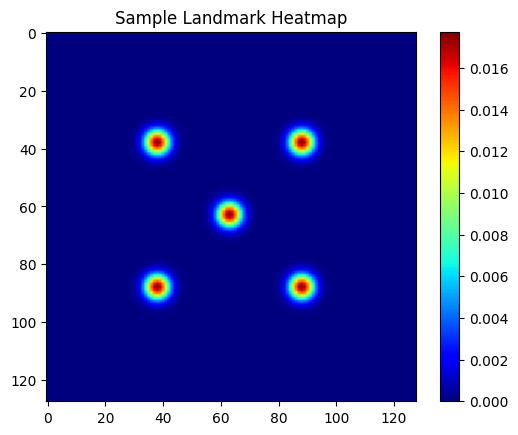

In [3]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

def generate_landmark_heatmap(landmarks, image_size, sigma=5):
    H, W = image_size
    heatmap = np.zeros((H, W), dtype=np.float32)

   
    if isinstance(landmarks, torch.Tensor):
        landmarks = landmarks.cpu().numpy()
    elif isinstance(landmarks, list):
        landmarks = np.array(landmarks)

    for i in range(0, len(landmarks), 2):
        x, y = landmarks[i], landmarks[i + 1]

        
        if x <= 1 and y <= 1:
            x = int(x * (W - 1))
            y = int(y * (H - 1))

        if x < 0 or x >= W or y < 0 or y >= H:
            continue

        
        size = int(6 * sigma + 1)
        gaussian = cv2.getGaussianKernel(size, sigma)
        gaussian = gaussian * gaussian.T

        x1 = x - size // 2
        y1 = y - size // 2
        x2 = x1 + size
        y2 = y1 + size

        gx1, gy1, gx2, gy2 = 0, 0, size, size

        if x1 < 0:
            gx1 = -x1
            x1 = 0
        if y1 < 0:
            gy1 = -y1
            y1 = 0
        if x2 > W:
            gx2 = size - (x2 - W)
            x2 = W
        if y2 > H:
            gy2 = size - (y2 - H)
            y2 = H

        heatmap[y1:y2, x1:x2] += gaussian[gy1:gy2, gx1:gx2]

    heatmap = np.clip(heatmap, 0, 1)
    return heatmap

sample_landmarks = torch.tensor([
    0.3, 0.3,  # Landmark 1
    0.7, 0.3,  # Landmark 2
    0.5, 0.5,  # Landmark 3
    0.3, 0.7,  # Landmark 4
    0.7, 0.7   # Landmark 5
])

image_size = (128, 128)
heatmap = generate_landmark_heatmap(sample_landmarks, image_size, sigma=3)

plt.imshow(heatmap, cmap='jet')
plt.title("Sample Landmark Heatmap")
plt.colorbar()
plt.show()


/work/AML_Project/5_Models/dataset_Openface_copy.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(fpath)  # {'tensor':..., 'eda':..., 'landmarks':...}

Scaled Landmarks: tensor([ 57.3793,  77.6951,  58.2989,  87.1832,  59.9540,  96.3133,  62.3448,
        105.2643,  66.2069, 113.3203,  72.0920, 120.1231,  80.3678, 124.7776,
         89.7471, 127.4629,  99.1264, 128.0000, 107.7701, 126.0308, 114.9425,
        121.7343, 120.8276, 116.0056, 124.1379, 108.1287, 125.9770,  99.5357,
        126.8966,  90.9427, 128.0000,  82.3497, 128.0000,  73.7566,  66.5747,
         70.7133,  72.0920,  66.2378,  79.2644,  64.8056,  86.6207,  65.8797,
         93.2414,  68.0280, 101.8851,  66.4168, 107.5862,  63.5524, 113.6552,
         61.7622, 119.9080,  62.4783, 123.9540,  66.5958,  98.2069,  73.3986,
         98.3908,  78.5902,  98.7586,  83.6028,  99.3103,  89.1525,  92.1379,
         95.4182,  95.8161,  96.1343,  99.3103,  96.6713, 102.4368,  95.9552,
        105.3793,  94.7021,  75.5862,  75.7259,  79.8161,  73.9357,  84.4138,
         73.7566,  88.4598,  75.9049,  84.2299,  76.9790,  79.8161,  77.1580,
        105.7471,  74.6517, 109.6092,  71.9664

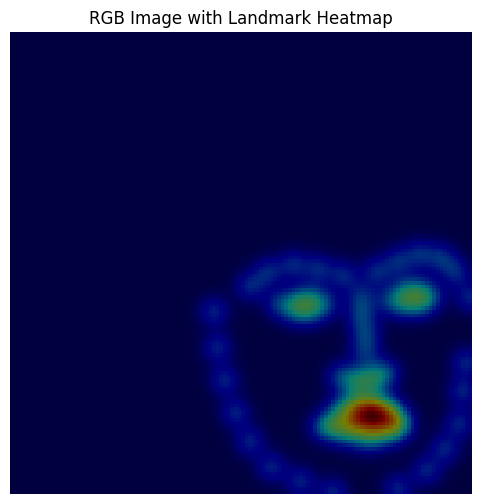

Scaled Landmarks: tensor([ 57.4619,  77.6951,  58.3827,  87.1832,  60.0403,  96.4923,  62.4345,
        105.4434,  66.3022, 113.4993,  72.1957, 120.1231,  80.4835, 124.7776,
         89.8763, 127.4629,  99.4532, 128.0000, 107.9252, 125.8518, 115.1079,
        121.5553, 120.8173, 115.6476, 124.1324, 107.9497, 125.9741,  99.5357,
        126.8950,  90.9427, 128.0000,  82.1706, 127.8158,  73.5776,  66.6705,
         70.3552,  72.0115,  65.8797,  79.0101,  64.4476,  86.3770,  65.7007,
         93.0072,  67.6699, 101.6633,  66.2378, 107.3727,  63.3734, 113.2662,
         61.4042, 119.5281,  62.1203, 123.5799,  66.2378,  97.7957,  73.2196,
         97.9799,  78.2322,  98.3482,  83.2448,  98.9007,  88.6154,  91.9022,
         95.0601,  95.4014,  95.7762,  98.9007,  96.3133, 102.2158,  95.5972,
        105.1626,  94.5231,  75.5108,  75.5469,  79.5626,  73.7566,  83.9827,
         73.5776,  88.0345,  75.5469,  83.9827,  76.8000,  79.5626,  76.9790,
        105.5309,  74.4727, 109.3986,  71.6084

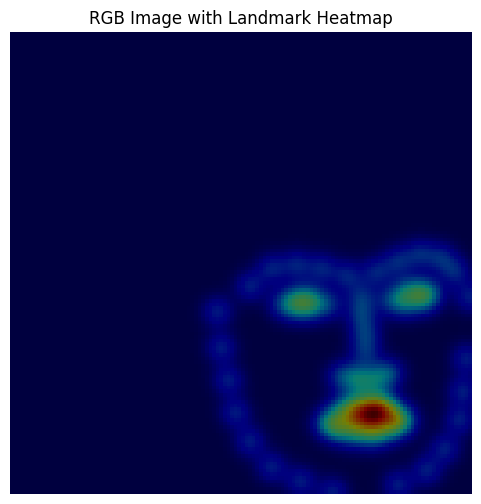

Scaled Landmarks: tensor([ 57.5817,  77.6569,  58.6819,  87.2971,  60.3324,  96.4017,  62.5330,
        105.3278,  66.2006, 113.3612,  72.0688, 120.1451,  80.5043, 124.7866,
         89.6734, 127.6430,  99.2092, 128.0000, 107.6447, 125.8577, 114.7966,
        121.5732, 120.4814, 115.8605, 123.7822, 108.3626, 125.6161,  99.9721,
        126.7163,  91.4031, 128.0000,  82.8340, 128.0000,  74.0865,  66.9341,
         70.8731,  72.2522,  66.5886,  79.4040,  65.1604,  86.5559,  66.4100,
         93.1576,  68.5523, 101.5931,  67.1241, 107.2779,  64.4463, 113.3295,
         62.6611, 119.7479,  63.3752, 123.7822,  67.4812,  97.9255,  73.7294,
         98.2923,  79.0851,  98.6590,  84.0837,  99.0258,  89.6179,  91.8739,
         95.6876,  95.3582,  96.5802,  99.0258,  96.9372, 102.1433,  96.4017,
        105.0774,  95.1520,  75.5530,  75.8717,  79.5874,  73.9080,  84.1719,
         73.7294,  88.3897,  76.0502,  84.1719,  77.1213,  79.5874,  77.2999,
        105.2607,  75.1576, 109.1118,  72.1227

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..1.0].


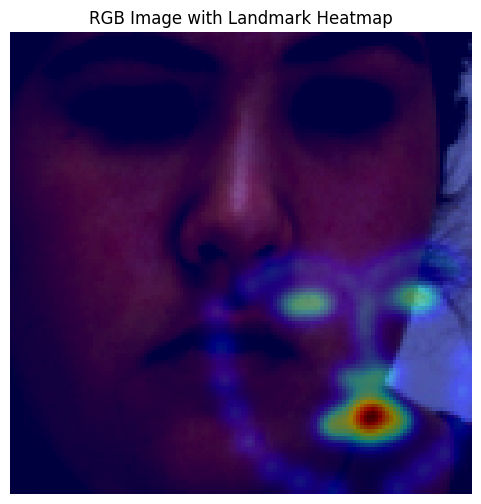

In [6]:
for window_frames, window_landmarks, window_eda in train_loader:
   
    combined_image = window_frames[0, 0] 
   
    rgb = combined_image[:3].cpu().numpy().transpose(1, 2, 0)
    heatmap = combined_image[3].cpu().numpy()
   
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("RGB Image with Landmark Heatmap")
    plt.axis('off')
    plt.show()

    break  
